# Import Module

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score

import datetime
import warnings
import os
import gc
warnings.filterwarnings('ignore')

print(os.listdir('../dataset'))

['sample_submission.csv', 'test_identity.csv', 'test_transaction.csv', 'train_identity.csv', 'train_transaction.csv']


# Load Data

In [2]:
# COLUMNS WITH STRINGS
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
str_type += ['id-12', 'id-15', 'id-16', 'id-23', 'id-27', 'id-28', 'id-29', 'id-30', 
            'id-31', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']

# FIRST 53 COLUMNS
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

# V COLUMNS TO LOAD DECIDED BY CORRELATION EDA
# https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]

#v += [96, 98, 99, 104] #relates to groups, no NAN 
v += [107, 108, 111, 115, 117, 120, 121, 123] # maybe group, no NAN
v += [124, 127, 129, 130, 136] # relates to groups, no NAN

# LOTS OF NAN BELOW
v += [138, 139, 142, 147, 156, 162] #b1
v += [165, 160, 166] #b1
v += [178, 176, 173, 182] #b2
v += [187, 203, 205, 207, 215] #b2
v += [169, 171, 175, 180, 185, 188, 198, 210, 209] #b2
v += [218, 223, 224, 226, 228, 229, 235] #b3
v += [240, 258, 257, 253, 252, 260, 261] #b3
v += [264, 266, 267, 274, 277] #b3
v += [220, 221, 234, 238, 250, 271] #b3

v += [294, 284, 285, 286, 291, 297] # relates to grous, no NAN
v += [303, 305, 307, 309, 310, 320] # relates to groups, no NAN
v += [281, 283, 289, 296, 301, 314] # relates to groups, no NAN
#v += [332, 325, 335, 338] # b4 lots NAN

cols += ['V'+str(x) for x in v]
dtypes = {}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]+['id-0'+str(x) for x in range(1,10)]+['id-'+str(x) for x in range(10,34)]:
    dtypes[c] = 'float32'
for c in str_type:
    dtypes[c] = 'category'
    


In [3]:
%%time

path = "../dataset/"
# LOAD TRAIN
X_train = pd.read_csv(path + 'train_transaction.csv', dtype=dtypes, usecols=cols+['isFraud'])
train_id = pd.read_csv(path + 'train_identity.csv', dtype=dtypes)
X_train = X_train.merge(train_id, how='left', on = 'TransactionID')

# LOAD TEST
X_test = pd.read_csv(path + 'test_transaction.csv', dtype=dtypes, usecols=cols)
test_id = pd.read_csv(path + 'test_identity.csv', dtype=dtypes)
fix = {o:n for o, n in zip(test_id.columns, train_id.columns)}
test_id.rename(columns=fix, inplace=True)
X_test = X_test.merge(test_id, how='left', on = 'TransactionID')

# TARGET
y_train = X_train['isFraud'].copy()

del train_id, test_id, X_train['isFraud']
gc.collect()

# PRINT STATUS
print('Train shape',X_train.shape,'test shape',X_test.shape)

Train shape (590540, 214) test shape (506691, 214)
Wall time: 41.3 s


# Normalizae D Columns

D 컬럼은 어느 한 과거 시점으로부터 경과한 시간을 나타낸다. 이 컬럼을 과거의 시점으로 변경한다. 이는, 시간의 경과에 따라 D 컬럼의 값이 증가하는 것을 방지할 것이다.

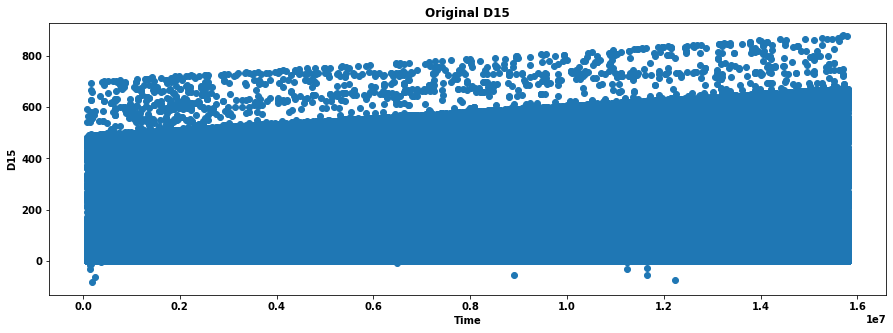

In [4]:
plt.figure(figsize = (15,5))
plt.scatter(X_train['TransactionDT'], X_train['D15'])

plt.title("Original D15")
plt.xlabel("Time")
plt.ylabel("D15")

plt.show()

## Normalize D Columns

In [5]:
for i in range(1, 16):
    if i in [1, 2, 3, 5, 9]:
        continue
        
    X_train['D' + str(i)] = X_train['D' + str(i)] - X_train['TransactionDT'] / np.float32(24 * 60 * 60)
    X_test['D' + str(i)] = X_test['D' + str(i)] - X_test['TransactionDT'] / np.float32(24 * 60 * 60)

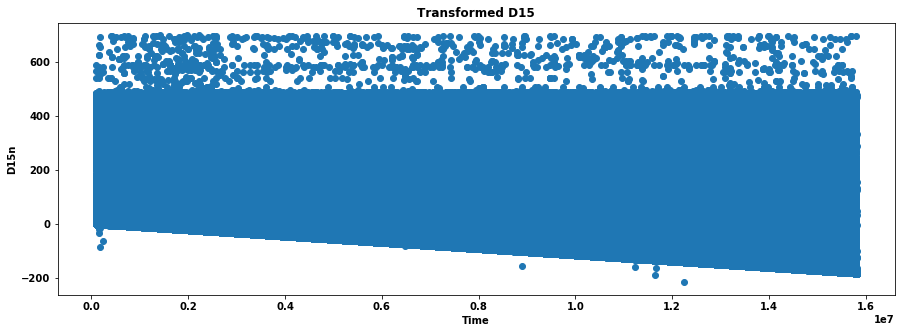

In [6]:
plt.figure(figsize = (15, 5))
plt.scatter(X_train['TransactionDT'], X_train['D15'])

plt.title('Transformed D15')
plt.xlabel("Time")
plt.ylabel("D15n")

plt.show()

# Label Encode & Memory Reduce

In [7]:
%%time

for i, f in enumerate(X_train.columns):
    if (np.str(X_train[f].dtype) == 'category') | (X_train[f].dtype == 'object'):
        df_comb = pd.concat([X_train[f], X_test[f]], axis = 0)
        df_comb, _  = df_comb.factorize(sort = True)
        
        if df_comb.max() > 32000:
            print(f, 'needs int 32')
        X_train[f] = df_comb[:len(X_train)].astype('int16')
        X_test[f] = df_comb[len(X_train):].astype('int16')
        
    elif f not in ['TransactionAmt', 'TransactionDT']:
        mn = np.min((X_train[f].min(), X_test[f].min()))
        X_train[f] -= np.float32(mn)
        X_test[f] -= np.float32(mn)
        X_train[f].fillna(-1, inplace = True)
        X_test[f].fillna(-1, inplace = True)

Wall time: 5.15 s


# Encoding Functions

인코딩 함수는 총 5개로 구성된다. 

첫 번째, encode_FE는 훈련 데이터와 테스트 데이터를 먼저 결합한 후, 빈도율을 인코딩한다.

두 번째, encode_LE는 범주형 변수를 위해 인코딩된 라벨 함수다.

세 번째, encode_AG는 평균 및 표준 편차를 집계하기 위한 함수다.

네 번째, encode_CB는 두 컬럼을 결합하는 함수다.

다섯 번째, encode_AG2는 한 그룹 내 몇 개의 고유값이 있는지 계산하는 집계 변수를 생성한다.

In [8]:
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col], df2[col]])
        vc = df.value_counts(dropna = True, normalize = True).to_dict()
        
        vc[-1] = -1
        nm = col + '_FE'
        
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[mn] = df2[nm].astype('float32')
        
        print(nm, ', ', end = '')
        
def encode_LE(col, train = X_train, test = X_test, verbose = True):
    df_comb = pd.concat([train[col], test[col]], axis = 0)
    df_comb, _ = df_comb.factorize(sort = True)
    nm = col
    
    if df_comb.max() > 32000:
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
        
    del df_comb
    gc.collect()
    
    if verbose:
        print(nm, ',', end = '')
        
def encode_AG(main_columns, uids, aggregations = ['mean'], train_df = X_train, test_df = X_test,
             fillna = True, usena = False):
    for main_column in main_columns:
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column + '_' + col + '_' + agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col, main_column]]])
                
                if usena:
                    temp_df.loc[temp_df[main_column] ==-1, main_column] = np.nan
                    temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(columns = {agg_type : new_col_name})
                    temp_df.index = list(temp_df[col])
                    temp_df = temp_df[new_col_name].to_dict()
                    
                    train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                    test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')

                    if fillna:
                        train_df[new_col_name].fillna(-1, inplace = True)
                        test_df[new_col_name].fillna(-1, inplace = True)
                        
                    print("'" + new_col_name + "'", ',', end = '')
                    
def encode_CB(col1, col2, df1 = X_train, df2 = X_test):
    nm = col1 + "_" + col2
    df1[nm] = df1[col1].astype(str) + '_' + df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str) + '_' + df2[col2].astype(str)
    
    encode_LE(nm, verbose = False)
    
    print(nm, ',', end = '')
    
def encode_AG2(main_columns, uids, train_df = X_train, test_df = X_test):
    for main_column in main_columns:
        for col in uids:
            comb = pd.concat([train_df[[col] + [main_column]], test_df[[col] + [main_column]]], axis = 0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')
            

# Feature Engineering

이제, 앞서 정의한 함수를 이용하여 새로운 파생변수를 생성한다. 생성된 모든 파생변수는 로컬 유효성 검사를 증가시키기 때문에 선택된다. 절차는 다음과 같다.

먼저, 함수를 이용하여 새로운 변수를 생성한다. 그 다음, 모델에 추가하여 로컬 유효성 검사 AUC가 증가하는지에 대한 여부를 평가한다. AUC가 증가하면 변수를 유지시키고 그렇지 않으면 변수를 제거한다.

In [9]:
%%time
# AMT CENTS
X_train['cents'] = (X_train['TransactionAmt'] - np.floor(X_train['TransactionAmt'])).astype('float32')
X_test['cents'] = (X_test['TransactionAmt'] - np.floor(X_test['TransactionAmt'])).astype('float32')

# encode_FE(Frequency Encode): Addr1, Card1, Card2, Card3, P_emaildomain
encode_FE(X_train, X_test, ['addr1', 'card1', 'card2', 'card3', 'P_emaildomain'])

# encode_CB(Combine Columns): Card1 + Addr1, Card1 + Addr1 + P_emaildomain
encode_CB('card1', 'addr1')
encode_CB('card1_addr1', 'P_emaildomain')

# encode_FE(Frequency Encode)
encode_FE(X_train, X_test, ['card1_addr1', 'card1_addr1_P_emaildomain'])

# Groupby Aggregate
encode_AG(['TransactionAmt', 'D9', 'D11'], ['card1', 'card1_addr1', 'card1_addr1_P_emaildomain'], ['mean','std'], usena = True)

addr1_FE , card1_FE , card2_FE , card3_FE , P_emaildomain_FE , card1_addr1 ,card1_addr1_P_emaildomain ,card1_addr1_FE , card1_addr1_P_emaildomain_FE , 'TransactionAmt_card1_mean' ,'TransactionAmt_card1_std' ,'TransactionAmt_card1_addr1_mean' ,'TransactionAmt_card1_addr1_std' ,'TransactionAmt_card1_addr1_P_emaildomain_mean' ,'TransactionAmt_card1_addr1_P_emaildomain_std' ,'D9_card1_mean' ,'D9_card1_std' ,'D9_card1_addr1_mean' ,'D9_card1_addr1_std' ,'D9_card1_addr1_P_emaildomain_mean' ,'D9_card1_addr1_P_emaildomain_std' ,'D11_card1_mean' ,'D11_card1_std' ,'D11_card1_addr1_mean' ,'D11_card1_addr1_std' ,'D11_card1_addr1_P_emaildomain_mean' ,'D11_card1_addr1_P_emaildomain_std' ,Wall time: 37.4 s


In [10]:
X_train.drop(columns = ['TransactionID'], inplace = True)
X_test.drop(columns =['TransactionID'], inplace = True)

#  Feature Selection - Time Consistency

Feature Engineering 과정을 통해 새로운 변수 28개를 추가했다. 상관분석을 통해 V219 컬럼을 제거했었다. 따라서 현재 우리는 242개의 변수를 가지고 있다. 이제, 242개 각각의 변수에 대해 "시간 일관성"을 점검할 것이다. 다음과 같은 절차를 따른다.

1. 242개의 모델을 구축한다. 각 모델은 훈련 데이터의 첫 달을 추출해 훈련을 수행하고 이 때, 하나의 변수만 사용한다.


2. 구축한 모델을 이용하여 훈련 데이터의 마지막 달을 예측한다. 

우리는 모델의 성능을 평가하기 위해 AUC를 사용하고, 검증 AUC가 0.5 이상이기를 원한다. 19개의 변수가 이 과정을 통해 제거될 것이다. 또한 대부분의 값이 NaN인 7개의 D 컬럼을 제거한다.

In [11]:
cols = list( X_train.columns )
cols.remove('TransactionDT')
for c in ['D6','D7','D8','D9','D12','D13','D14']:
    cols.remove(c)
    
# FAILED TIME CONSISTENCY TEST
for c in ['C3','M5','id_08','id_33']:
    cols.remove(c)
for c in ['card4','id_07','id_14','id_21','id_30','id_32','id_34']:
    cols.remove(c)
for c in ['id_'+str(x) for x in range(22,28)]:
    cols.remove(c)

In [12]:
print('NOW USING THE FOLLOWING',len(cols),'FEATURES.')
np.array(cols)

NOW USING THE FOLLOWING 216 FEATURES.


array(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5',
       'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5',
       'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M6', 'M7', 'M8',
       'M9', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17',
       'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41',
       'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62', 'V65', 'V67',
       'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89',
       'V91', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121',
       'V123', 'V124', 'V127', 'V129', 'V130', 'V136', 'V138', 'V139',
       'V142', 'V147', 'V156', 'V160', 'V162', 'V165', 'V166', 'V169',
       'V171', 'V173', 'V175', 'V176', 'V178', 'V180', 'V182', 'V185',
       'V187', 'V188', 'V198', 'V203', 'V205', 'V207', 'V209', 'V210',
       '

# Local Validation
이번 대회에서는 시간 기반 Local Validation을 활용했다. 가장 기본적인 머신러닝 학습 방법은 데이터의 처음 75%를 훈련 데이터로 사용하고 마지막 25%를 테스트 데이터로 사용하여 모델을 평가하는 것이다. 그러나 또다른 방법은 전체 데이터에서 첫 4개월을 훈련 데이터로 사용했고 한 달을 건너뛰고, 마지막 달을 예측하고 모델을 평가하는 방법이다.

In [13]:
# Common method: Train 75% Test 25%
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

# Train 4 Skip 1 Predict 1 Month
# idxT = X_train.index[:417559]
# idxV = X_train.index[-89326:]

In [14]:
"""
params = {'n_estimators' : 2000,
         'max_depth' : 12,
         'learning_rate' : 0.02,
         'subsample' : 0.8,
         'colsample_bytree:' : 0.4,
         'missing': -1,
         'eval_metric': 'auc',
         'tree_method' : 'gpu_hist',
         'random_state' : 42}

clf = xgb.XGBClassifier(**params)
h = clf.fit(X_train.loc[idxT, cols], y_train[idxT],
           eval_set = [(X_train.loc[idxT, cols], y_train[idxT]), (X_train.loc[idxV, cols], y_train[idxV])],
           verbose = 50, early_stopping_rounds = 100)
"""

"\nparams = {'n_estimators' : 2000,\n         'max_depth' : 12,\n         'learning_rate' : 0.02,\n         'subsample' : 0.8,\n         'colsample_bytree:' : 0.4,\n         'missing': -1,\n         'eval_metric': 'auc',\n         'tree_method' : 'gpu_hist',\n         'random_state' : 42}\n\nclf = xgb.XGBClassifier(**params)\nh = clf.fit(X_train.loc[idxT, cols], y_train[idxT],\n           eval_set = [(X_train.loc[idxT, cols], y_train[idxT]), (X_train.loc[idxV, cols], y_train[idxV])],\n           verbose = 50, early_stopping_rounds = 100)\n"

In [15]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_, cols)), columns = ['Value', 'Feature'])

plt.figure(figsize = (20, 10))
sns.barplot(x = 'Value', y = 'Feature', data = feature_imp.sort_values(by = 'Value', ascending = False).iloc[:50])
plt.title('XGB Most Important Features')
plt.tight_layout()
plt.show()

NameError: name 'clf' is not defined

# Predict test.csv

이제, 몇 달을 그룹으로 묶어 test.csv에 대한 예측을 수행한다. 모델 성능을 평가하기 위해 GroupKFold를 사용한다. 훈련 데이터는 2017년 12월, 2018년 1월, 2018년 2월, 2018년 3월, 2018년 4월, 2018년 5월이다. 이 달들을 12, 13, 14, 15, 16, 17이라고 부른다. GroupKFold의 Fold 하나는 13~17까지 훈련하고 12에 대해 예측을 수행한다.

In [16]:
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
X_train['DT_M'] = X_train['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_train['DT_M'] = (X_train['DT_M'].dt.year-2017) * 12 + X_train['DT_M'].dt.month

X_test['DT_M'] = X_test['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_test['DT_M'] = (X_test['DT_M'].dt.year-2017) * 12 + X_test['DT_M'].dt.month

gc.collect()

83

In [ ]:
oof = np.zeros(len(X_train))
preds = np.zeros(len(X_test))

skf = GroupKFold(n_splits = 6)

for i, (tr_idx, val_idx) in enumerate(skf.split(X_train, y_train, groups = X_train['DT_M'])):
    month = X_train.iloc[val_idx]['DT_M'].iloc[0]
    
    print("FOLD {} withholding month {}".format(i, month))
    print("Rows of Train = {} Rows of Holdout = {}".format(len(tr_idx), len(val_idx)))
    
    params = {'n_estimators' : 5000,
             'max_depth' : 12,
             'learning_rate' : 0.02,
             'subsample' : 0.8,
             'colsample_bytree' : 0.4,
             'missing' : -1,
              'eval_metric' : 'auc',
              'tree_method' : 'gpu_hist',
              'random_state' : 42
             }
    clf = xgb.XGBClassifier(**params)
    
    h = clf.fit(X_train[cols].iloc[tr_idx], y_train.iloc[tr_idx],
               eval_set = [(X_train[cols].iloc[tr_idx], y_train.iloc[tr_idx]), (X_train[cols].iloc[val_idx], y_train.iloc[val_idx])],
               verbose = 100, early_stopping_rounds = 100)
    
    oof[val_idx] += clf.predict_proba(X_train[cols].iloc[val_idx])[:, 1]
    preds += clf.predict_proba(X_test[cols])[:, 1] / skf.n_splits
    
    del h, clf
    gc.collect()
    
    print('#' * 20)
    print('XGB OOF CV = ', roc_auc_score(y_train, oof))

FOLD 0 withholding month 12
Rows of Train = 453219 Rows of Holdout = 137321
[0]	validation_0-auc:0.854942	validation_1-auc:0.815902
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.942795	validation_1-auc:0.870631
[200]	validation_0-auc:0.977316	validation_1-auc:0.891292
[300]	validation_0-auc:0.992437	validation_1-auc:0.901717
[400]	validation_0-auc:0.99685	validation_1-auc:0.906102
[500]	validation_0-auc:0.998392	validation_1-auc:0.907458
[600]	validation_0-auc:0.999091	validation_1-auc:0.906823
Stopping. Best iteration:
[514]	validation_0-auc:0.998498	validation_1-auc:0.907641

